In [1]:
# Import pandas 
import pandas as pd

# Read in white wine data 
white = pd.read_csv('winequality-white.csv', sep=';')

# Read in red wine data 
red = pd.read_csv('winequality-red.csv', sep=';')

In [2]:

# Add `type` column to `red` with value 1
red['type'] = 1

# Add `type` column to `white` with value 0
white['type'] = 0

# Append `white` to `red`
#wines = red.append(white, ignore_index=True)
wines = pd.concat([red, white], ignore_index=True)

In [3]:
wines

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,0
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,0
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,0


In [4]:

X=wines.iloc[:,0:12]

In [5]:

X=wines.drop('quality',axis=1)

In [6]:

# Isolate target labels
#Y = wines.quality
import numpy as np 
Y=np.ravel(wines.quality)

In [7]:

# Import `StandardScaler` from `sklearn.preprocessing`
from sklearn.preprocessing import StandardScaler

# Scale
X_train=StandardScaler().fit_transform(X)

In [8]:
# Import `Sequential` from `keras.models`
from keras import Sequential

# Import `Dense` from `keras.layers`
from keras.layers import Dense
from keras.layers import Input
import keras

import numpy as np
from sklearn.model_selection import StratifiedKFold

seed = 140421
np.random.seed(seed)
keras.utils.set_random_seed(seed)

test = np.random.choice(X_train.shape[0], size=int(X_train.shape[0]*0.2), replace=False)
mse_vals = []
mae_vals = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for train, val in kfold.split(X, Y):
    model = Sequential()
    model.add(Input(shape=(12, )))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    model.fit(X_train[train], Y[train], epochs=10,verbose=0)
    mse_aux_value, mae_aux_value=model.evaluate(X_train[val], Y[val], verbose=0)
    mse_vals.append(mse_aux_value)
    mae_vals.append(mae_aux_value)

mse_val_value = np.mean(mse_vals)
mae_val_value = np.mean(mae_vals)

#En caso de haber guardado un modelo...
y_test_pred = model.predict(X_train[test])
mse_test_value, mae_test_value=model.evaluate(X_train[test], Y[test], verbose=0)

print(f'Validation MSE: {mse_val_value:.5f}')
print(f'Validation MAE: {mae_val_value:.5f}')
print(f'Test MSE: {mse_test_value:.5f}')
print(f'Test MAE: {mae_test_value:.5f}') 


2025-02-08 10:22:47.118549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739006567.137546   16048 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739006567.140949   16048 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-08 10:22:47.157702: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1739006568.695014   16048 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 97

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation MSE: 0.52078
Validation MAE: 0.55884
Test MSE: 0.49805
Test MAE: 0.54303


In [9]:
from sklearn.metrics import r2_score
r2_score(Y[test],y_test_pred)

0.35863226652145386

# Experimentamos aumentar el número de iteraciones

In [10]:
# Import pandas 
import pandas as pd
import numpy as np 
from sklearn.preprocessing import StandardScaler

# Read in white wine data 
white = pd.read_csv('winequality-white.csv', sep=';')
# Read in red wine data 
red = pd.read_csv('winequality-red.csv', sep=';')
# Add `type` column to `red` with value 1
red['type'] = 1
# Add `type` column to `white` with value 0
white['type'] = 0
# Append `white` to `red`
#wines = red.append(white, ignore_index=True)
wines = pd.concat([red, white], ignore_index=True)
X=wines.iloc[:,0:12]
X=wines.drop('quality',axis=1)
# Isolate target labels
#Y = wines.quality
Y=np.ravel(wines.quality)
# Import `StandardScaler` from `sklearn.preprocessing`
# Scale
X_train=StandardScaler().fit_transform(X)

In [12]:
# Import `Sequential` from `keras.models`
import os 
import matplotlib.pyplot as plt
from keras import Sequential

# Import `Dense` from `keras.layers`
from keras.layers import Dense
from keras.layers import Input
import keras

import numpy as np
from sklearn.model_selection import StratifiedKFold

seed = 140421
np.random.seed(seed)
keras.utils.set_random_seed(seed)

test = np.random.choice(X_train.shape[0], size=int(X_train.shape[0]*0.2), replace=False)
mse_vals = []
mae_vals = []

k_folds = 5
kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)
epochs = 50

def train_loop(
  epochs, 
  kfold,
  filename,
  layer_configs,
  logger_kwargs=None,
  compiler_kwargs=None
):
  if not logger_kwargs:
    logger_kwargs = {}
  default_compiler_kwargs = dict(optimizer="rmsprop", loss='mse', metrics=['mae'])
  if not compiler_kwargs:
    compiler_kwargs = {}
  default_compiler_kwargs = {**default_compiler_kwargs, **compiler_kwargs}
  # Keras callback to save the train error in each epoch
  _reset_opt = default_compiler_kwargs.pop("_reset_opt", None)
  if os.path.exists(filename):
    os.remove(filename)
  csv_logger = keras.callbacks.CSVLogger(filename, **logger_kwargs)
  for train, val in kfold.split(X, Y):
    model = Sequential()
    model.add(Input(shape=(12, )))
    for config in layer_configs:
      model.add(Dense(config, activation='relu'))
    model.add(Dense(1))
    if _reset_opt is not None:
      default_compiler_kwargs["optimizer"] = _reset_opt()
    model.compile(**default_compiler_kwargs) # TODO: Review thos
    model.fit(
      X_train[train],
      Y[train],
      epochs=epochs,
      verbose=0,
      callbacks=[csv_logger],
      validation_data=(X_train[val], Y[val]),
    )
  # Ojo: Solo estamos devolviendo el último modelo de validación, no el mejor.
  return model

In [13]:
filename = "epochs_logger.csv"
model = train_loop(epochs=epochs, kfold=kfold, filename=filename, layer_configs=[64], logger_kwargs={"append": True})

In [16]:
import polars as pl 
def read_dataframe(filename):
  train_df = pl.read_csv(filename)
  train_df = train_df.with_columns(pl.lit([k for _ in range(epochs) for k in range(k_folds)]).alias("k_fold"))
  return train_df

train_df = read_dataframe(filename)

def read_test_results(model):
  mse_test_value, mae_test_value = model.evaluate(
    X_train[test],
    Y[test],
    verbose=0
  )
  return mse_test_value, mae_test_value

def get_results(train_df, model,):
  mse_val_value = train_df["val_loss"].mean()
  mae_val_value = train_df["val_mae"].mean()

  mse_test_value, mae_test_value = read_test_results(model,)

  return mse_val_value, mae_val_value, mse_test_value, mae_test_value

def print_results(mse_val_value, mae_val_value, mse_test_value, mae_test_value):
  print(f'Validation MSE: {mse_val_value:.5f}', end="\t")
  print(f'Validation MAE: {mae_val_value:.5f}')
  print(f'Test MSE: {mse_test_value:.5f}', end="\t")
  print(f'Test MAE: {mae_test_value:.5f}') 

print_results(*get_results(train_df, model))

Validation MSE: 0.56389	Validation MAE: 0.57467
Test MSE: 0.45272	Test MAE: 0.51946


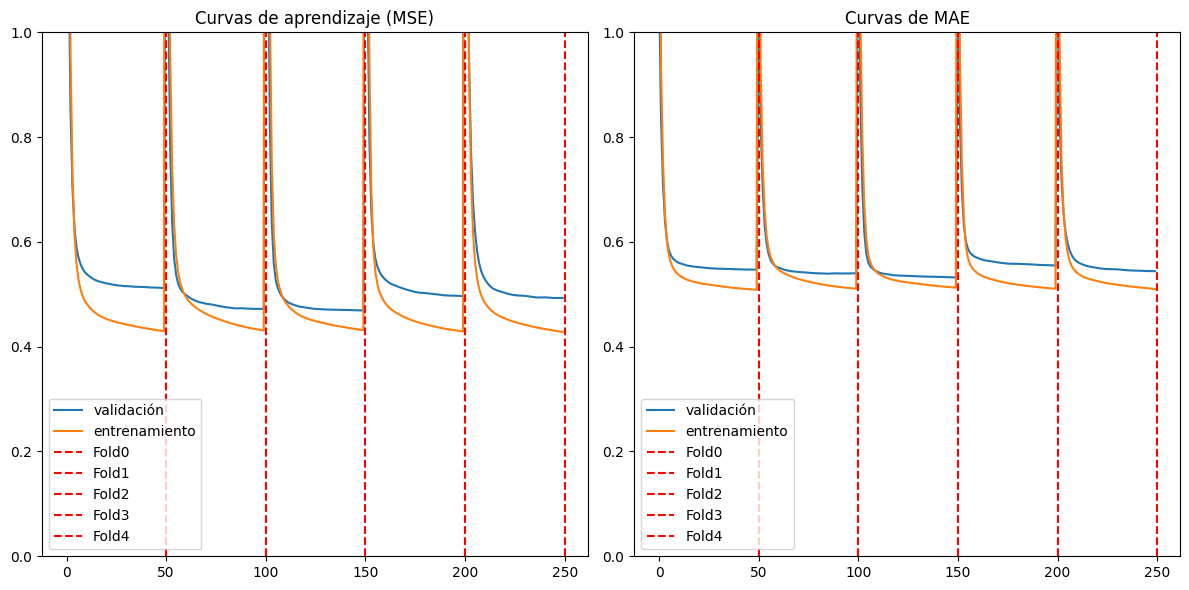

In [17]:
def plot_training_curves(train_df, epochs, k_folds):
  fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(12, 6))
  mse_train, mse_vals = train_df["loss"].to_list(), train_df["val_loss"].to_list()
  mae_train, mae_vals = train_df["mae"].to_list(), train_df["val_mae"].to_list()
  length = range(epochs * k_folds)
  ax[0].plot(length, mse_vals, label="validación")
  ax[0].plot(length, mse_train, label="entrenamiento")
  for k in range(k_folds):
    ax[0].axvline(x=epochs * (k+1), label=f"Fold{k}", color = "red", linestyle="dashed")
  ax[0].set_title("Curvas de aprendizaje (MSE)")
  # ax[0].set_ylim((0, 1.0))
  ax[0].legend()
  ax[1].plot(length, mae_vals, label="validación")
  ax[1].plot(length, mae_train, label="entrenamiento")
  for k in range(k_folds):
    ax[1].axvline(x=epochs * (k+1), label=f"Fold{k}", color = "red", linestyle="dashed")
  ax[1].set_title("Curvas de MAE")
  # ax[1].set_ylim((0, 1.0))
  ax[1].legend()
  return fig, ax

fig, ax = plot_training_curves(train_df, epochs, k_folds)
ax[0].set_ylim((0, 1))
ax[1].set_ylim((0, 1))
plt.show()

En la Figura anterior observamos el comportamiento de las curvas de aprendizaje de nuestro modelo para los diferentes pliegues de validación. Notamos que a medida que crece el número de iteraciones la distancia entre la curva de aprendizaje de entrenamiento y la de validación aumenta. Es decir, nuestro modelo empezaría a sobre-entrenar dado que empieza a aprender rasgos de nuestros datos de entrenamiento que no tienen porque generalizar bien. Es un comportamiento similar a lo que observamos en la práctica anterior al aumentar la complejidad del modelo. Ambos hechos pueden llegar a producir el mismo efecto. Es necesario tomar medidas de regularización para controlar la capacidad de generalización del modelo ("Bias and Variance Trade-off").

# Experimentamos agregar más capas

A sabiendas del anterior, vamos a probar aumentar el número de capas ocultas manteniendo el número de unidades y observando el promedio de clasificación de validación. Sabemos, que si ocurre sobre-entrenamiento, de forma similar a lo visto anteriormente, dicho error de validación crecerá. Esperamos observamos el comportamiento

In [18]:
np.random.seed(140421)
keras.utils.set_random_seed(140421)
layer_configs = [[64, 64], [64, 64, 64], [64, 64, 64, 64]]
if not os.path.exists("csvs/"):
  os.mkdir("csvs/")
filename = "csvs/layers.csv"
mse_val, mae_val = [], []
for layer_config in layer_configs:
  model = train_loop(epochs=20, kfold=kfold, filename=filename, layer_configs=layer_config, logger_kwargs={"append": False})
  train_df = read_dataframe(filename)
  results = get_results(train_df=train_df, model=model)
  mse_val.append(results[0])
  mae_val.append(results[1])

In [19]:
df = pl.DataFrame({"mse": mse_val, "mae": mae_val, "config": [len(layer_config) for layer_config in layer_configs]})
df 

mse,mae,config
f64,f64,i64
0.681822,0.628492,2
0.715731,0.647251,3
0.685627,0.63634,4


Efectivamente, observamos que al incrementar el número de capas ocultas con 64 unidades de 2 a 4 la capacidad de generalización disminuye al observar el cambio en tendencia, podríamos tener más robustez en esta afirmación incrementando el tamaño máximo de 4 a 8, pero por restricciones computacionales 4 será el máximo. 

# Observar el comportamiento de la tasa de aprendizaje

In [20]:
from keras.optimizers import RMSprop 
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
# tf.compat.v2.enable_v2_behavior()
np.random.seed(140421)
keras.utils.set_random_seed(140421)
opt = lambda: RMSprop(learning_rate=0.0001)
compiler_kwargs = dict(_reset_opt=opt)#, run_eagerly=True)
filename = "csvs/learning_rate.csv"
epochs = 5
model = train_loop(epochs=epochs, kfold=StratifiedKFold(2), filename=filename, logger_kwargs={"append": False}, compiler_kwargs=compiler_kwargs, layer_configs=[64])
train_df = read_dataframe(filename)
train_df

epoch,loss,mae,val_loss,val_mae,k_fold
i64,f64,f64,f64,f64,list[i64]
0,30.152864,5.388406,31.332489,5.532356,"[0, 1, … 4]"
1,25.903677,4.944114,29.030441,5.318007,"[0, 1, … 4]"
2,22.130667,4.495754,26.750277,5.095747,"[0, 1, … 4]"
3,18.822372,4.048503,24.470814,4.863133,"[0, 1, … 4]"
4,16.00948,3.624542,22.171427,4.615906,"[0, 1, … 4]"


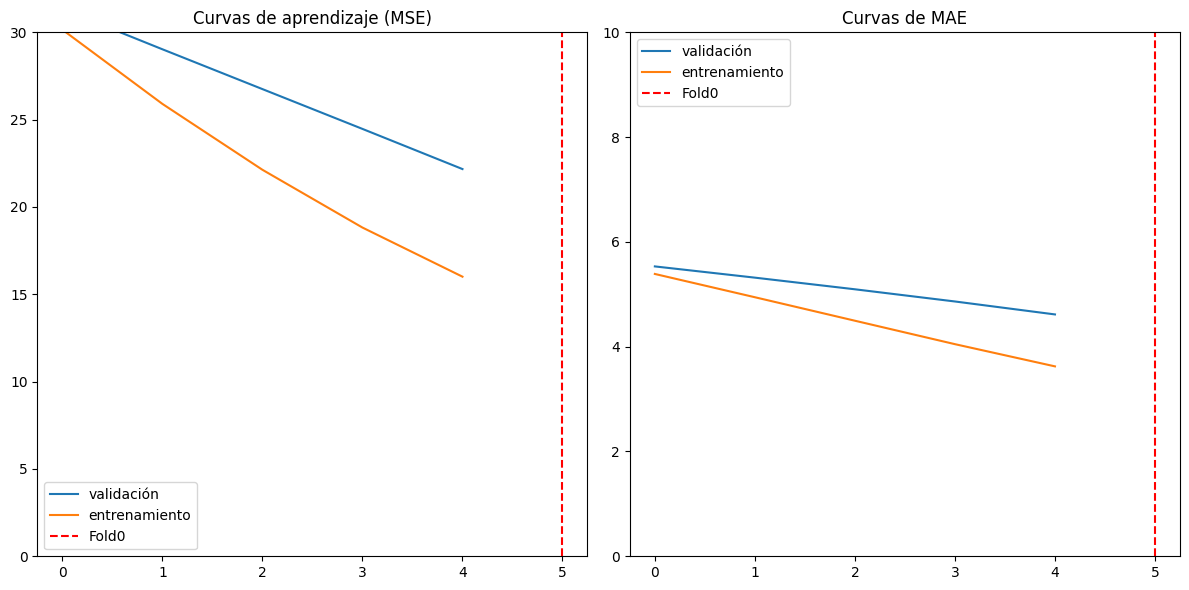

In [21]:
fig, ax = plot_training_curves(train_df, epochs, 1)
ax[0].set_ylim((0, 30))
ax[1].set_ylim((0, 10))
plt.show()

Observamos que si el LearningRate es muy pequeño, el aprendizaje del modelo es extremadamente lento.

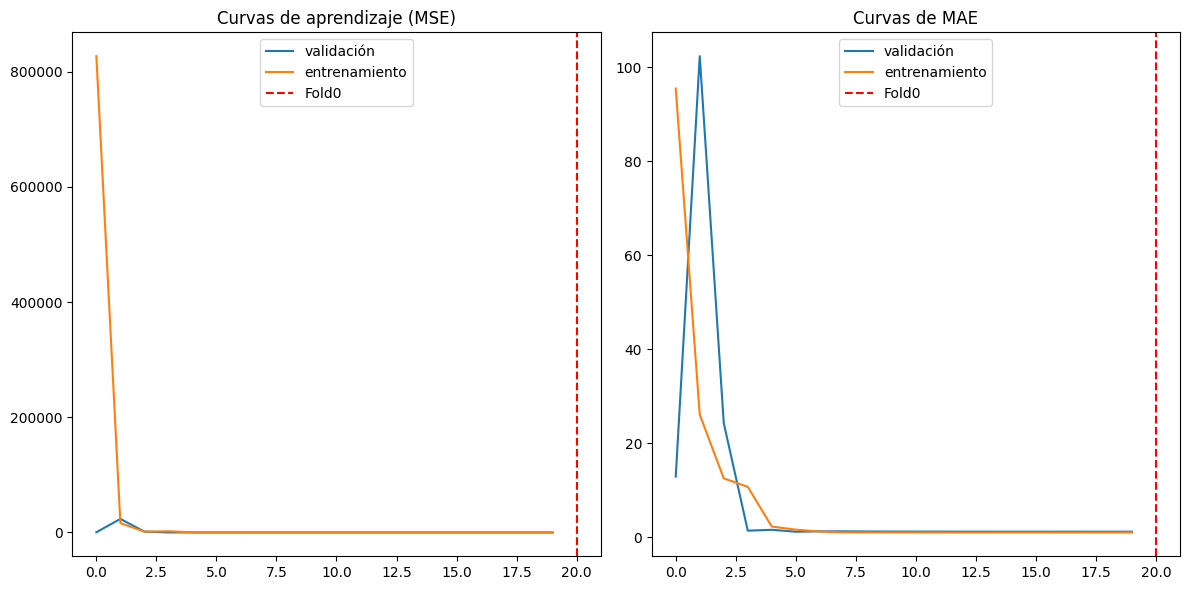

In [22]:
from keras.optimizers import RMSprop
np.random.seed(140421)
keras.utils.set_random_seed(140421)
compiler_kwargs = dict(_reset_opt=lambda: RMSprop(learning_rate=2.0))
filename = "csvs/learning_rate.csv"
epochs = 20
model = train_loop(epochs=epochs, kfold=StratifiedKFold(2), filename=filename, logger_kwargs={"append": False}, compiler_kwargs=compiler_kwargs, layer_configs=[64])
train_df = read_dataframe(filename)
fig, ax = plot_training_curves(train_df, epochs, 1)
plt.show()

Vemos que con un learning rate más grande observamos un aprendizaje más rápido pero también tenemos saltos de aprendizajes algo bruscos.

# Experimentamos con SGD

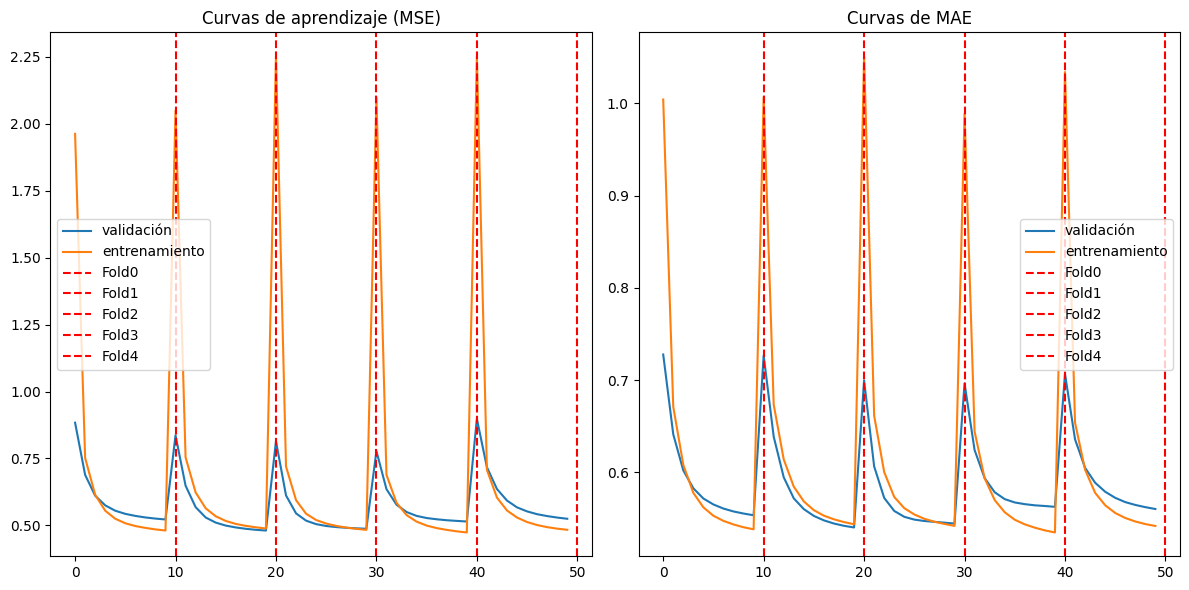

In [23]:
from keras.optimizers import SGD
np.random.seed(140421)
keras.utils.set_random_seed(140421)
compiler_kwargs = dict(_reset_opt=lambda: SGD())
filename = "csvs/sgd.csv"
epochs = 10
model = train_loop(epochs=epochs, kfold=kfold, filename=filename, logger_kwargs={"append": True}, compiler_kwargs=compiler_kwargs, layer_configs=[64])
train_df = read_dataframe(filename)
fig, ax = plot_training_curves(train_df, epochs, k_folds)
plt.show()

In [24]:
print_results(*get_results(train_df, model))

Validation MSE: 0.57465	Validation MAE: 0.58572
Test MSE: 0.49213	Test MAE: 0.53781


Para este problema obtenemos resultados un poco peores con respecto al uso del optimizador RMSProp.

# ¿Cuál es la mejor combinación?

Aparentemente, para este problema, observamos un comportamiento positivo al uso del optimizador RSMProp con sus valores por defecto. Además, la profundidad más adecuada aparenta ser de 3 unidades ocultas. Podemos probar variar el número de unidades, proyectando a una mayor dimensión sin saltos tan elevados. Incluso, podríamos hacer uso de una rejilla de parámetros y configuraciones para automatizar la búsqueda de parámetros que maximizen nuestros resultados. No obstante, mi intuición indica una solución básica como la siguiente será adecuada:

Validation MSE: 0.60626	Validation MAE: 0.59712
Test MSE: 0.56705	Test MAE: 0.59660


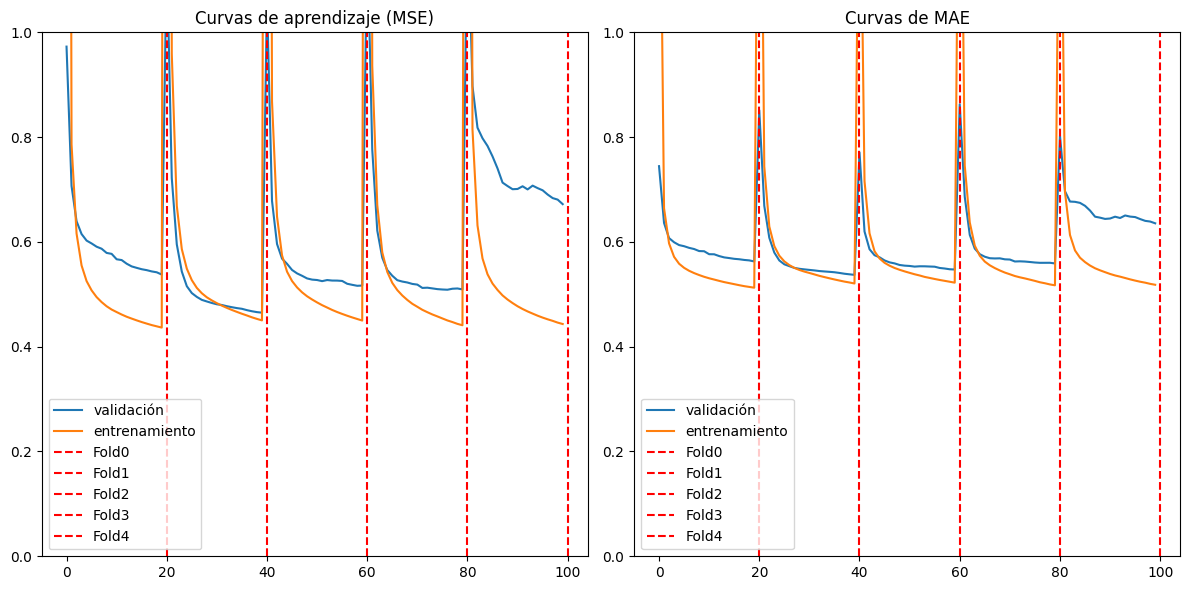

In [25]:
np.random.seed(140421)
keras.utils.set_random_seed(140421)
layer_configs = [[32, 64, 32]]
if not os.path.exists("csvs/"):
  os.mkdir("csvs/")
filename = "csvs/layers.csv"
epochs = 20
model = train_loop(epochs=epochs, kfold=kfold, filename=filename, layer_configs=layer_configs[0], logger_kwargs={"append": True})
train_df = read_dataframe(filename)
results = get_results(train_df=train_df, model=model)
fig, ax = plot_training_curves(train_df, epochs, k_folds)
ax[0].set_ylim((0, 1))
ax[1].set_ylim((0, 1))
print_results(*results)
plt.show()